# Text Classification of StackOverflow using BiLSTM RNNs with deep self-attention

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import talos as ta
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from definitions import  TALOS_DIR
from app.preprocessing import (load_dataset, load_embeddings,
                               preprocess_data, save_embeddings_matrix)
from app.models import load_bi_lstm_model, find_best_model_over_scan_logs
from app.metrics import *

#Comment out In case of Testing use only a set of the tags as dataset
tags_categories = ['c', 'python', 'java']
RUN_STATE = 'testing'

# Comment out In case of Production use all the tags of the dataset
# tags_categories = "__all__"
# RUN_STATE = 'production'

Using TensorFlow backend.


## Preprocessing for the loaded Dataset
1. Format into *lowercase*
2. Remove some of the *punctuation* characters
3. Remove *Numbers*
4. Remove *stopwords*
5. Remove *links*

In [2]:
data = load_dataset(tags_categories=tags_categories, load_from_pickle=True)
classes_counts =data['tags'].value_counts().where(lambda cls: cls > 0).dropna() 
Classes = list(classes_counts.index)
Nclasses = len(Classes)
print(classes_counts, Classes, Nclasses)

python    2000.0
c         2000.0
java      2000.0
Name: tags, dtype: float64 ['python', 'c', 'java'] 3


In [3]:
# 70% Train & 30% Test
# 70% Train-Dev % 30* Train-Dev 
embeddings_voc, embeddings_vec = load_embeddings(load_from_pickle=True)
model_data = preprocess_data(data, 'tags', 'post', cv_split_dev=0.125)
embeddings_matrix_path = save_embeddings_matrix(embeddings_voc, 
                                                embeddings_vec, 
                                                model_data['words_index'])

In [4]:
model_data['x_train'][4]

array([  100,     2,   342,  2517,   599,    10,   452,  3686,   240,
          87,   100,     2,   420,   593,   112,  5572,    67,   934,
          16,    69,    10,   113,     3,     2,    32, 13392,     2,
           3,    64,    16,     3,     2,   622,     2,     3,   386,
           3,     2,   708,   240,    77,   189,   141,    32,   240,
         268,    32,    77,   114,   268,     7,    32,    32,   126,
         268,   240,   268,   463,   240,   268,    40,   240,   268,
          16,   240,    77,   708,   240,   240,   141,   240,     5,
         141,   708,   240,   240,    40,   708,   240,    16,   651,
           2,     3,   162,     3,     2, 13393,     2,     3,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## Models Definition and Hyperparameter Tuning

> Below it will be defined, trained and evaluate the 2 models of RNNs the first with a unistack RNN with BiLSTM and MLP on top of it and the second with a multistack RNN with BiLSTM and MLP on top of it. 
The hyperparameter tuning is implemented throw the Talos library and will calculate the best configuration for each of the 2 models.

### UniStacked RNN with BiLSTM

In [5]:
###### Production configuration
rnn_deep_lstm_config = {
    "model_type": ["keras_deep_LSTM_model"],
    "embedding_dim": [embeddings_vec.shape[1]],
    "lstm_size": [200],
    "dense": [300],
    "embeddings_matrix_path": [embeddings_matrix_path],
    "visualize_process": [True],
    "with_early_stoping": [True],
    "multistack_run": [False],
    'early_stopping':[True],
    'early_stopping_config__monitor': ['val_f1'],
    'early_stopping_config__min_delta': [0],
    'early_stopping_config__patience': [5],
    'early_stopping_config__mode': ['max'],
    "embeddings_dropout": [0.2],
    "var_dropout": [0.2, 0.6],
    "mlp_dropout": [0.2],
    "mlp_activation": ["softmax"],
    "rnn_activation": ["relu", "tanh"],
    "optimizer": ["Nadam", "Adam"],
    "batch_size": [32, 64],
    "epochs": [3 if RUN_STATE == 'testing' else 10]
}

In [6]:
TALOS_LSTM_DEEP_LOG_FILENAME = 'talos_lstm_deep_log'
if RUN_STATE == 'testing': 
    TALOS_LSTM_DEEP_LOG_FILENAME += '_test'
talos_lstm_deep_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_LOG_FILENAME)

history_model = ta.Scan(model_data['x_train'],
                        model_data['y_train'],
                        x_val=model_data['x_train_dev'],
                        y_val=model_data['y_train_dev'],
                        model=load_bi_lstm_model,
                        params=rnn_deep_lstm_config,
                        grid_downsample=0.1,
                        print_params=True,
                        last_epoch_value=True,
                        seed=(123),
                        dataset_name=talos_lstm_deep_log_pathname
                        )


  0%|          | 0/1 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0717 20:34:01.866691 140211821410112 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 20:34:01.893723 140211821410112 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 20:34:01.955558 140211821410112 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 20:34:01.967225 140211821410112 deprecation_wrapper.py:119] From /home/giannhs/minicon

{'model_type': 'keras_deep_LSTM_model', 'embedding_dim': 300, 'lstm_size': 200, 'dense': 300, 'embeddings_matrix_path': 'embeddings-matrix-pickle', 'visualize_process': True, 'with_early_stoping': True, 'multistack_run': False, 'early_stopping': True, 'early_stopping_config__monitor': 'val_f1', 'early_stopping_config__min_delta': 0, 'early_stopping_config__patience': 5, 'early_stopping_config__mode': 'max', 'embeddings_dropout': 0.2, 'var_dropout': 0.6, 'mlp_dropout': 0.2, 'mlp_activation': 'softmax', 'rnn_activation': 'tanh', 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 3}


W0717 20:34:02.265912 140211821410112 deprecation.py:506] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0717 20:34:02.589401 140211821410112 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0717 20:34:02.610338 140211821410112 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0717 20:34:02.633059 140211821410112 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0717 20:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 400)          801600    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 400), (None, 600) 160801    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total para


Epoch 00001: val_accuracy improved from -inf to 0.93397, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.89812, saving model to keras_deep_LSTM_model



Epoch 00002: val_accuracy improved from 0.93397 to 0.96127, saving model to keras_deep_LSTM_model

Epoch 00002: val_f1 improved from 0.89812 to 0.94066, saving model to keras_deep_LSTM_model



Epoch 00003: val_accuracy improved from 0.96127 to 0.97143, saving model to keras_deep_LSTM_model

Epoch 00003: val_f1 improved from 0.94066 to 0.95663, saving model to keras_deep_LSTM_model


100%|██████████| 1/1 [11:57<00:00, 717.93s/it]


> Finds the best model configuration based for our RNN based on the highest value of the *val_f1*.

In [7]:
report_talos = ta.Reporting(history_model)
best_model_idx = report_talos.data['val_f1'].idxmax()
best_model_params = report_talos.data.loc[best_model_idx].to_dict()
best_model_params

{'round_epochs': 3,
 'val_loss': 0.12583526128459543,
 'val_precision': 0.9669692993164063,
 'val_recall': 0.9466666666666667,
 'val_f1': 0.9566344052269345,
 'val_accuracy': 0.9714285641624814,
 'val_categorical_accuracy': 0.9561904761904761,
 'loss': 0.14965055934020452,
 'precision': 0.9551755591152477,
 'recall': 0.934149659750413,
 'f1': 0.9444695093518212,
 'accuracy': 0.9634467200843655,
 'categorical_accuracy': 0.9434013605442176,
 'model_type': 'keras_deep_LSTM_model',
 'embedding_dim': 300,
 'lstm_size': 200,
 'dense': 300,
 'embeddings_matrix_path': 'embeddings-matrix-pickle',
 'visualize_process': 'True',
 'with_early_stoping': 'True',
 'multistack_run': 'False',
 'early_stopping': 'True',
 'early_stopping_config__monitor': 'val_f1',
 'early_stopping_config__min_delta': 0,
 'early_stopping_config__patience': 5,
 'early_stopping_config__mode': 'max',
 'embeddings_dropout': 0.2,
 'var_dropout': 0.6,
 'mlp_dropout': 0.2,
 'mlp_activation': 'softmax',
 'rnn_activation': 'tanh',

> Train a new RNN model based on the best Talos configuration.

 ****Note: the below cells have been explicitly removed from the PRODUCTION run because they required an extra model generation which was demanding in terms of recources and time. For extra information about the PRODUCTION run check the README instructions.*

In [8]:
if RUN_STATE == 'testing':
    # Train and Load the best model of given the tuned featured model
    best_model_params['early_stopping'] = True
    best_model_params['with_early_stopping'] = True
    best_model_params['visualize_process'] = True
    model_history, model = load_bi_lstm_model(model_data['x_train'],
                                              model_data['y_train'],
                                              model_data['x_train_dev'],
                                              model_data['y_train_dev'],
                                              best_model_params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 400)          801600    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 400), (None, 600) 160801    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total para


Epoch 00001: val_accuracy improved from -inf to 0.92952, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.88912, saving model to keras_deep_LSTM_model



Epoch 00002: val_accuracy improved from 0.92952 to 0.96825, saving model to keras_deep_LSTM_model

Epoch 00002: val_f1 improved from 0.88912 to 0.95142, saving model to keras_deep_LSTM_model



Epoch 00003: val_accuracy improved from 0.96825 to 0.97333, saving model to keras_deep_LSTM_model

Epoch 00003: val_f1 improved from 0.95142 to 0.95950, saving model to keras_deep_LSTM_model



### Visualize Model History Scores

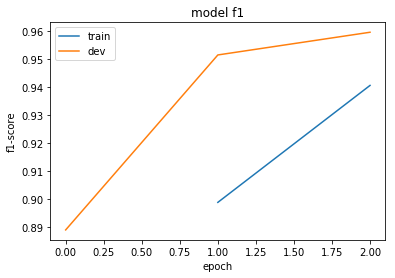

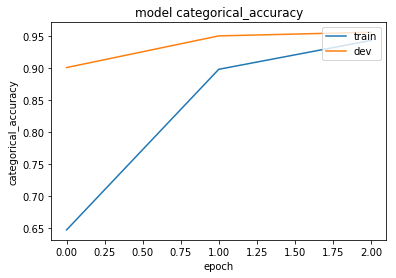

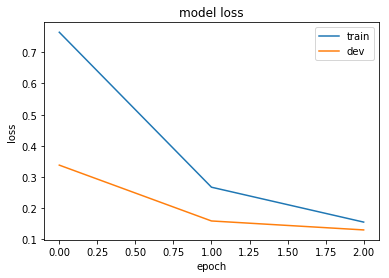

In [9]:
if RUN_STATE == 'testing':
    from app.visualization import plot_history_metrics
    import matplotlib.pylab as plt

    %matplotlib inline
    plot_history_metrics(history_obj=model_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [10]:
if RUN_STATE == 'testing':
    score = model.evaluate(model_data['x_test'],
                           model_data['y_test'],
                           batch_size=best_model_params['batch_size'],
                           verbose=1)

    print('\nTest f1: %.4f' % (score[1]))
    print('\nTest categorical accuracy: %.4f'% (score[2]))

1800/1800 [==============================] - 40s 22ms/step

Test f1: 0.9605

Test categorical accuracy: 0.9344


### Visualize Prediction Perfomance  model

--------------------------------------------------------------------------------
Accuracy Score: 94.50%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.964     0.950     0.957       600
           1      0.944     0.930     0.937       600
           2      0.974     0.923     0.948       600

   micro avg      0.961     0.934     0.947      1800
   macro avg      0.961     0.934     0.947      1800
weighted avg      0.961     0.934     0.947      1800
 samples avg      0.934     0.934     0.934      1800



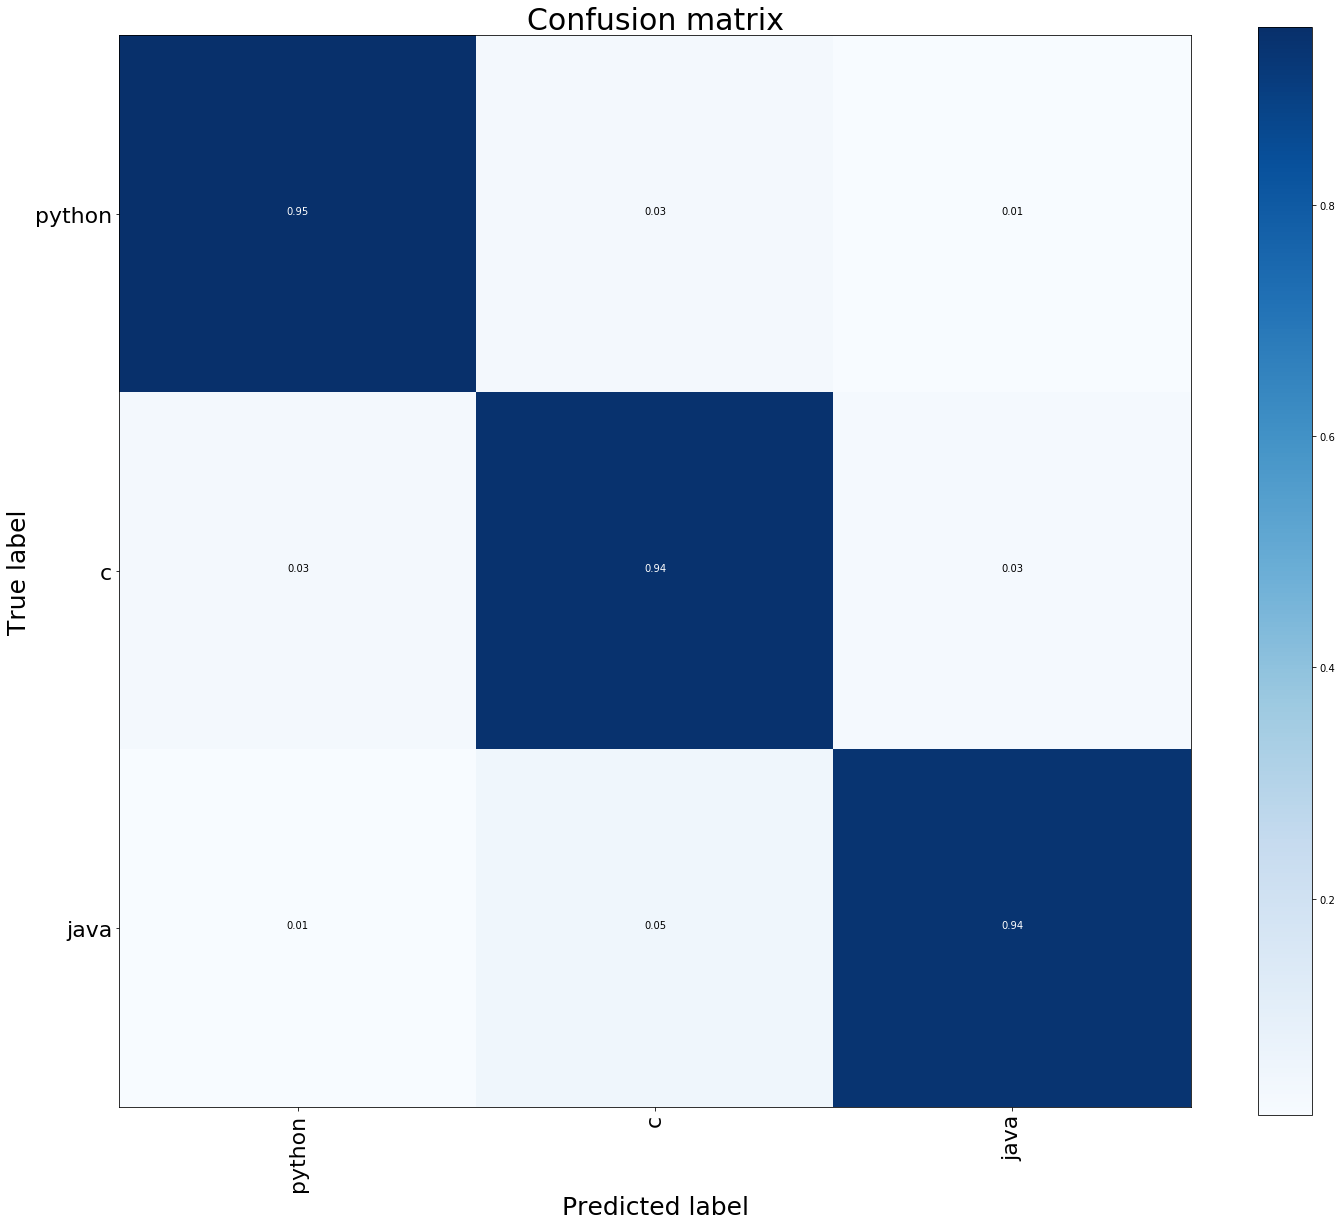

In [11]:
if RUN_STATE == 'testing':
    import numpy as np
    from app.visualization import (plot_prediction_metrics,
                                   create_clf_report,
                                   plot_roc_curve,
                                   plot_precision_recall_curve,
                                   plot_confusion_matrix)
    import matplotlib.pylab as plt

    prediction_val = model.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

    # returns each entry result to the classification with the relevant probabilities
    y_pred_processed = np.array([np.argmax(val) for val in prediction_val])
    y_true_processed = np.array([np.argmax(val) for val in model_data['y_test']])

    # If you want to see the OneVSAll ROC Curves of each class uncomment the below line
    # plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

    # If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
    # plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

    # If you want to get the Classification Report, comment out the below line
    create_clf_report(model_data['y_test'], (prediction_val > 0.5).astype('int32'),
                      y_true_processed, y_pred_processed)

    # If you want to get the confusion matrix,comment out the below line
    plot_confusion_matrix(y_true_processed, y_pred_processed, Classes)

### Multistack RNN with BiLSTM

In [12]:
TALOS_LSTM_DEEP_MULTI_LOG_FILENAME = 'talos_lstm_deep_multi_log'
if RUN_STATE == 'testing': 
    TALOS_LSTM_DEEP_MULTI_LOG_FILENAME += '_test'
talos_lstm_deep_multi_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_MULTI_LOG_FILENAME)


###### Production configuration
rnn_deep_lstm_multi_config = rnn_deep_lstm_config.copy()
rnn_deep_lstm_multi_config.update({
    "model_type": ["keras_deep_LSTM_multi_model"],
    "multistack_run": [True],
})

history_model_multi = ta.Scan(model_data['x_train'],
                        model_data['y_train'],
                        x_val=model_data['x_train_dev'],
                        y_val=model_data['y_train_dev'],
                        model=load_bi_lstm_model,
                        params=rnn_deep_lstm_multi_config,
                        grid_downsample=0.1,
                        print_params=True,
                        last_epoch_value=True,
                        seed=(123),
                        dataset_name=talos_lstm_deep_multi_log_pathname
                        )


  0%|          | 0/1 [00:00<?, ?it/s]

{'model_type': 'keras_deep_LSTM_multi_model', 'embedding_dim': 300, 'lstm_size': 200, 'dense': 300, 'embeddings_matrix_path': 'embeddings-matrix-pickle', 'visualize_process': True, 'with_early_stoping': True, 'multistack_run': True, 'early_stopping': True, 'early_stopping_config__monitor': 'val_f1', 'early_stopping_config__min_delta': 0, 'early_stopping_config__patience': 5, 'early_stopping_config__mode': 'max', 'embeddings_dropout': 0.2, 'var_dropout': 0.6, 'mlp_dropout': 0.2, 'mlp_activation': 'softmax', 'rnn_activation': 'relu', 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 3}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_3 (Dro


Epoch 00001: val_accuracy improved from -inf to 0.88635, saving model to keras_deep_LSTM_multi_model

Epoch 00001: val_f1 improved from -inf to 0.82086, saving model to keras_deep_LSTM_multi_model



Epoch 00002: val_accuracy improved from 0.88635 to 0.95175, saving model to keras_deep_LSTM_multi_model

Epoch 00002: val_f1 improved from 0.82086 to 0.92636, saving model to keras_deep_LSTM_multi_model



Epoch 00003: val_accuracy improved from 0.95175 to 0.96889, saving model to keras_deep_LSTM_multi_model

Epoch 00003: val_f1 improved from 0.92636 to 0.95267, saving model to keras_deep_LSTM_multi_model


100%|██████████| 1/1 [20:24<00:00, 1224.82s/it]


> Finds the best model configuration based for our RNN based on the highest value of the *val_f1*.

In [13]:
report_talos_multi = ta.Reporting(history_model_multi)
best_model_idx = report_talos_multi.data['val_f1'].idxmax()
best_model_params_multi = report_talos_multi.data.loc[best_model_idx].to_dict()
best_model_params_multi

{'round_epochs': 3,
 'val_loss': 0.15226248816365287,
 'val_precision': 0.9590402003696986,
 'val_recall': 0.9466666666666667,
 'val_f1': 0.9526699029831659,
 'val_accuracy': 0.9688888840448289,
 'val_categorical_accuracy': 0.9485714285714286,
 'loss': 0.24240215558584044,
 'precision': 0.9276906081121795,
 'recall': 0.9023129250565354,
 'f1': 0.9146028338484212,
 'accuracy': 0.9440362853744403,
 'categorical_accuracy': 0.9148299318592564,
 'model_type': 'keras_deep_LSTM_multi_model',
 'embedding_dim': 300,
 'lstm_size': 200,
 'dense': 300,
 'embeddings_matrix_path': 'embeddings-matrix-pickle',
 'visualize_process': 'True',
 'with_early_stoping': 'True',
 'multistack_run': 'True',
 'early_stopping': 'True',
 'early_stopping_config__monitor': 'val_f1',
 'early_stopping_config__min_delta': 0,
 'early_stopping_config__patience': 5,
 'early_stopping_config__mode': 'max',
 'embeddings_dropout': 0.2,
 'var_dropout': 0.6,
 'mlp_dropout': 0.2,
 'mlp_activation': 'softmax',
 'rnn_activation': '

> Train a new RNN model based on the best Talos configuration.


In [14]:
if RUN_STATE == 'testing':
    # Train and Load the best model of given the tuned featured model
    model_history_multi, model_multi = load_bi_lstm_model(model_data['x_train'],
                                                          model_data['y_train'],
                                                          model_data['x_train_dev'],
                                                          model_data['y_train_dev'],
                                                          best_model_params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 400)          801600    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 400), (None, 600) 160801    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total para


Epoch 00001: val_accuracy improved from -inf to 0.94349, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.91161, saving model to keras_deep_LSTM_model



Epoch 00002: val_accuracy improved from 0.94349 to 0.96190, saving model to keras_deep_LSTM_model

Epoch 00002: val_f1 improved from 0.91161 to 0.94162, saving model to keras_deep_LSTM_model



Epoch 00003: val_accuracy improved from 0.96190 to 0.97460, saving model to keras_deep_LSTM_model

Epoch 00003: val_f1 improved from 0.94162 to 0.96156, saving model to keras_deep_LSTM_model



### Visualize Model History Scores

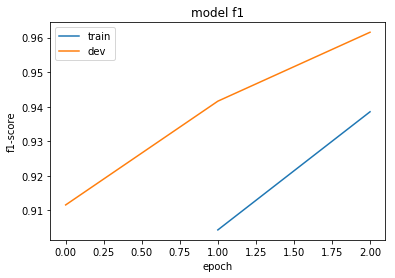

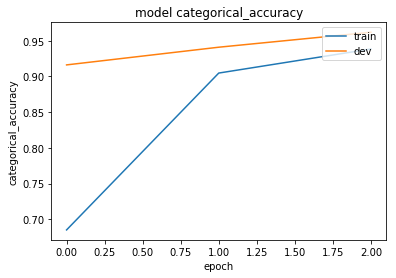

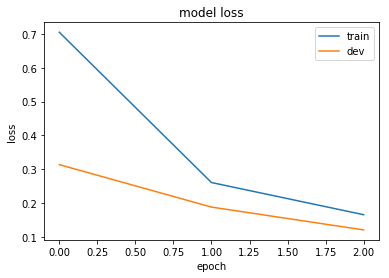

In [16]:
if RUN_STATE == 'testing':
    from app.visualization import plot_history_metrics
    import matplotlib.pylab as plt

    %matplotlib inline
    plot_history_metrics(history_obj=model_history_multi)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [17]:
if RUN_STATE == 'testing':
    score_multi = model_multi.evaluate(model_data['x_test'],
                                       model_data['y_test'],
                                       batch_size=best_model_params_multi['batch_size'],
                                       verbose=1)

    print('\nTest f1: %.4f' % (score_multi[1]))
    print('\nTest categorical accuracy: %.4f'% (score_multi[2]))

1800/1800 [==============================] - 41s 23ms/step

Test f1: 0.9532

Test categorical accuracy: 0.9383


### Visualize Prediction Perfomance  model

--------------------------------------------------------------------------------
Accuracy Score: 94.39%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.972     0.942     0.957       600
           1      0.916     0.950     0.933       600
           2      0.974     0.923     0.948       600

   micro avg      0.953     0.938     0.946      1800
   macro avg      0.954     0.938     0.946      1800
weighted avg      0.954     0.938     0.946      1800
 samples avg      0.938     0.938     0.938      1800



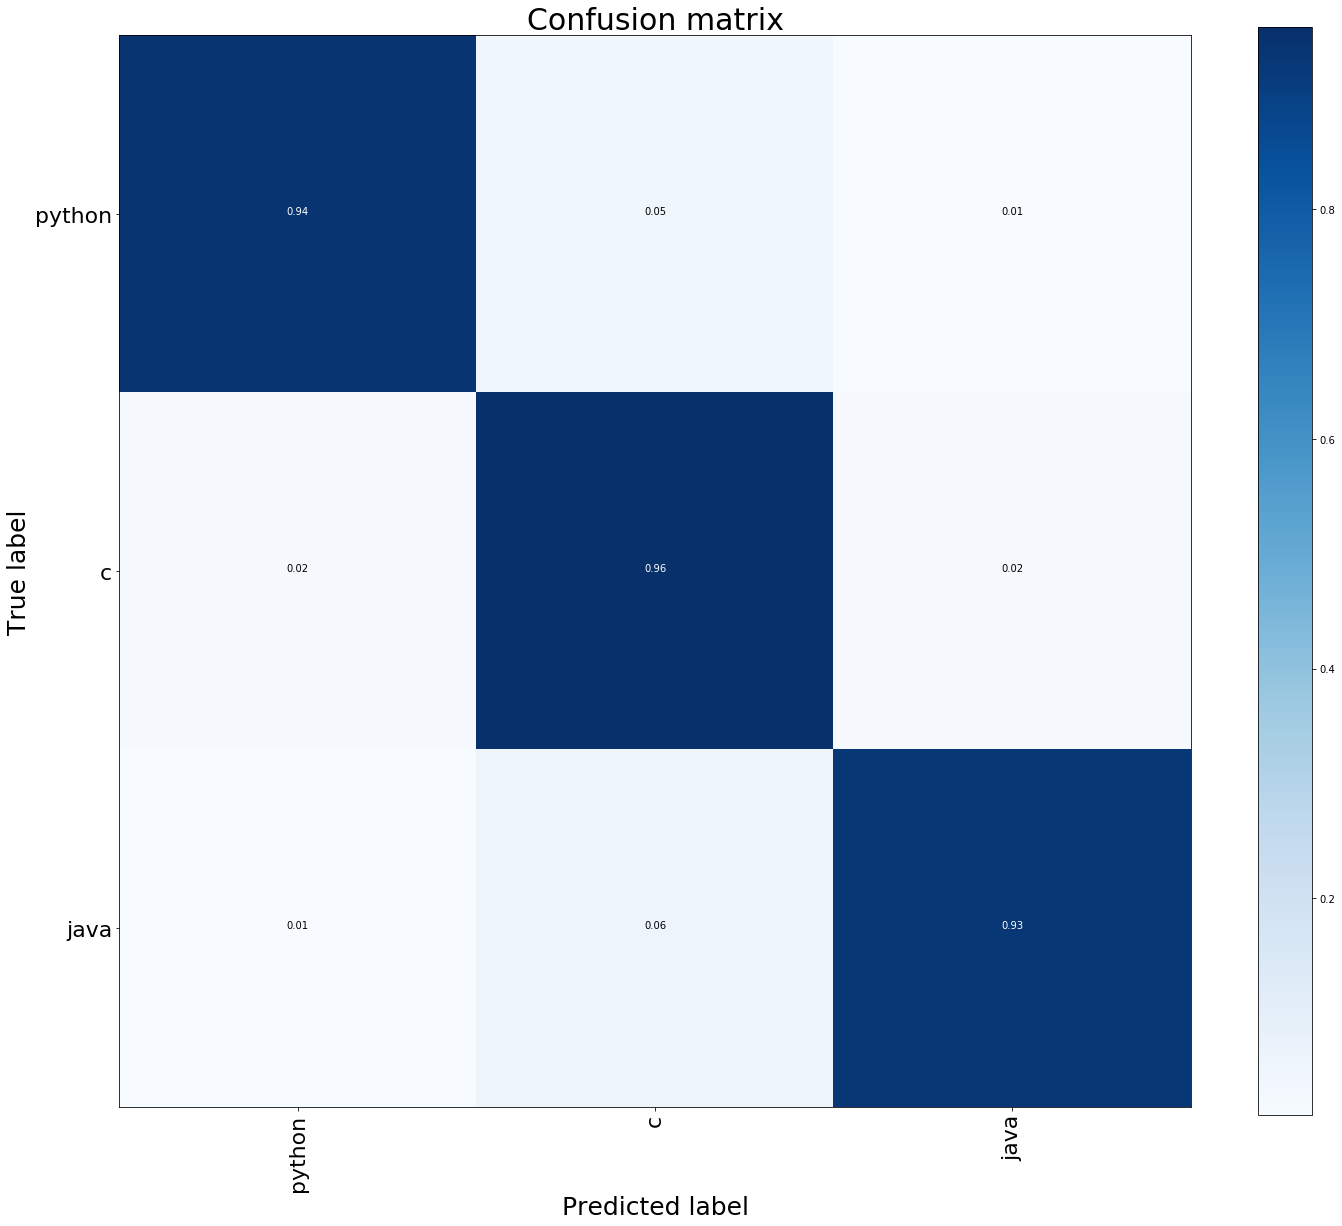

In [22]:
if RUN_STATE == 'testing':
    import numpy as np
    from app.visualization import (plot_prediction_metrics,
                                   create_clf_report,
                                   plot_roc_curve,
                                   plot_precision_recall_curve,
                                   plot_confusion_matrix)
    import matplotlib.pylab as plt

    prediction_val_multi = model_multi.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

    # returns each entry result to the classification with the relevant probabilities
    y_pred_processed_multi = np.array([np.argmax(val) for val in prediction_val_multi])
    y_true_processed_multi = np.array([np.argmax(val) for val in model_data['y_test']])

    # If you want to see the OneVSAll ROC Curves of each class uncomment the below line
    # plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

    # If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
    # plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

    # If you want to get the Classification Report, comment out the below line
    create_clf_report(model_data['y_test'], (prediction_val_multi > 0.5).astype('int32'),
                      y_true_processed_multi, y_pred_processed_multi)

    # If you want to get the confusion matrix,comment out the below line
    plot_confusion_matrix(y_true_processed_multi, y_pred_processed_multi, Classes)